In [54]:
'''Clean up trip data files into unified dataset

'''

# %% Initialize
import glob
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

import geocoder


In [2]:
# Load Hubway CSVs
path = 'data/'
baseName = '-hubway-tripdata.csv'

# files = glob.glob(f'{path}/*{baseName}')
files = glob.glob(f'{path}*{baseName}')

data_hubway = pd.DataFrame()
for f in files:
    df = pd.read_csv(f)

    data_hubway = pd.concat([data_hubway, df])

data_hubway.to_pickle(f'{path}hubway-tripdata.pkl')
print(data_hubway.columns.values)

['tripduration' 'starttime' 'stoptime' 'start station id'
 'start station name' 'start station latitude' 'start station longitude'
 'end station id' 'end station name' 'end station latitude'
 'end station longitude' 'bikeid' 'usertype' 'birth year' 'gender']


In [3]:
# Get Bluebike CSV column counts
# Determine when format changes happened
path = 'data/'
baseName = '-bluebikes-tripdata.csv'

files = glob.glob(f'{path}*{baseName}')

lastCols = []
changefmt = []

for i, f in enumerate(files):
    df = pd.read_csv(f)
    # print(f'{i} - {f}: {len(df.columns)}')

    if lastCols != list(df.columns):
        # print(i)
        changefmt.append(i)

    lastCols = list(df.columns)

changefmt.append(i)

print(f'{changefmt=}')




changefmt=[0, 24, 49, 52]


In [4]:
# Load Bluebike CSVs
for x in range(len(changefmt)-1):
    s = changefmt[x]
    e = changefmt[x+1]

    data_BB = pd.DataFrame()
    for f in files[s:e]:
        df = pd.read_csv(f)
        data_BB = pd.concat([data_BB, df], ignore_index=True)

    data_BB.to_pickle(f'{path}bluebike-tripdata-{x+1}.pkl')
    print(data_BB.columns.values)

['tripduration' 'starttime' 'stoptime' 'start station id'
 'start station name' 'start station latitude' 'start station longitude'
 'end station id' 'end station name' 'end station latitude'
 'end station longitude' 'bikeid' 'usertype' 'birth year' 'gender']
['tripduration' 'starttime' 'stoptime' 'start station id'
 'start station name' 'start station latitude' 'start station longitude'
 'end station id' 'end station name' 'end station latitude'
 'end station longitude' 'bikeid' 'usertype' 'postal code']
['ride_id' 'rideable_type' 'started_at' 'ended_at' 'start_station_name'
 'start_station_id' 'end_station_name' 'end_station_id' 'start_lat'
 'start_lng' 'end_lat' 'end_lng' 'member_casual']


In [5]:
# Clean up data
data = pd.read_pickle(f'{path}bluebike-tripdata-1.pkl')

data['starttime'] = pd.to_datetime(data['starttime'], format='%Y-%m-%d %H:%M:%S')
data['stoptime'] = pd.to_datetime(data['stoptime'], format='%Y-%m-%d %H:%M:%S')

data['gender'].replace(0, np.nan, inplace=True)

data['usertype'].replace('Subscriber', 1, inplace=True)
data['usertype'].replace('Customer', 0, inplace=True)

In [6]:
# Create (reverse-)geocoded station list
def station_list(data):
    stationListStart = data[['start station id', 'start station name','start station latitude', 'start station longitude']].sort_values('start station id').drop_duplicates('start station id', keep='last').reset_index()
    stationListEnd = data[['end station id', 'end station name','end station latitude', 'end station longitude']].sort_values('end station id').drop_duplicates('end station id', keep='last').reset_index()

    colNames = ['index', 'station_id', 'station_name','latitude', 'longitude']
    stationListStart.columns = colNames
    stationListEnd.columns = colNames

    stationList = pd.concat([stationListStart, stationListEnd], ignore_index=True)
    stationList = stationList.sort_values('station_id').drop_duplicates('station_id', keep='last').reset_index()
    stationList = stationList.drop(['index', 'level_0'], axis=1)

    print(stationList[['station_id', 'latitude', 'longitude']].head())

    def geo_rev(x):
        g = geocoder.osm([x.latitude, x.longitude], method='reverse').json
        if g:
            return g.get('city')
        else:
            return 'no city'

    stationList['city'] = stationList[['latitude', 'longitude']].apply(geo_rev, axis=1)

    stationList.to_pickle('stationlist.pkl')

    return stationList

# stationList = station_list(data)# Analyze Data
stationList = pd.read_pickle('stationlist.pkl')

# Gender - Zero=unknown; 1=male; 2=female
gender = data.groupby(by=[data['starttime'].dt.date]).agg({'gender': 'mean'})
gender = gender - 1

# Age
data['age'] = data['starttime'].dt.year - data['birth year']
# a = np.array(data['age'].values.tolist())
# data['age'] = np.where(a > 90, np.nan, a).tolist()
# data['age'][data['age'] > 90] = np.nan

# User type
usertype = data.groupby(by=[data['starttime'].dt.date]).agg({'usertype': 'mean'})


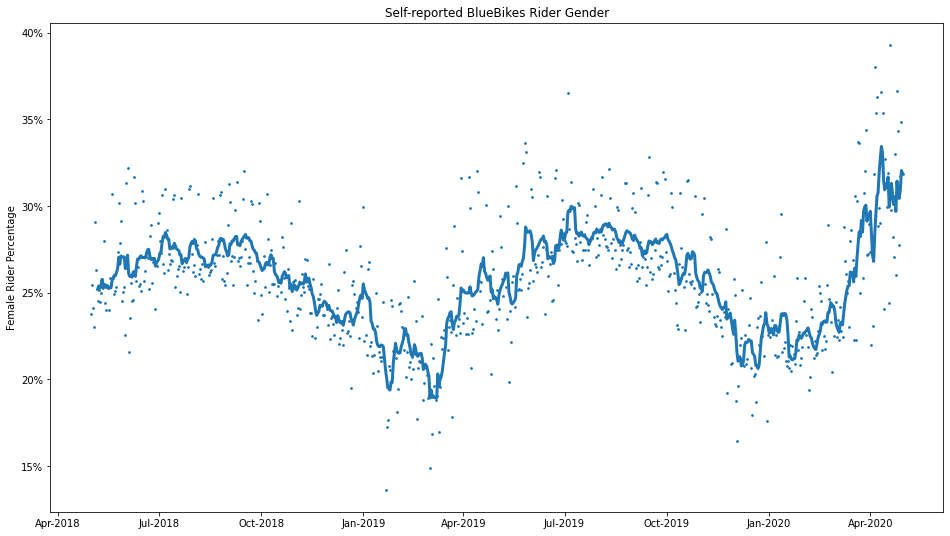

In [28]:
# Plots! - Gender
fig = plt.figure(figsize=(16,9), facecolor='white')
ax = fig.add_subplot(1,1,1)

gender_roll = gender.rolling(7).mean()
ax.scatter(gender.index, gender['gender'], s=3)
ax.plot(gender_roll, linewidth=3)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.set_ylabel('Female Rider Percentage')
ax.set_title('Self-reported BlueBikes Rider Gender')
plt.show()

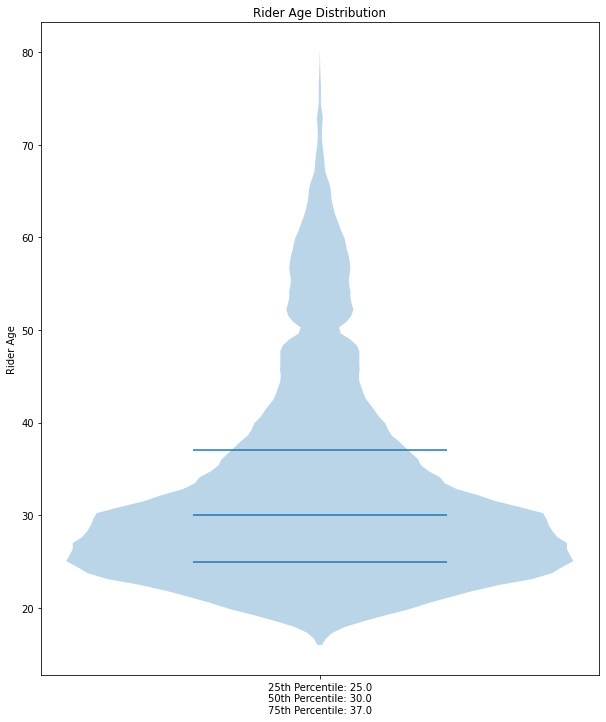

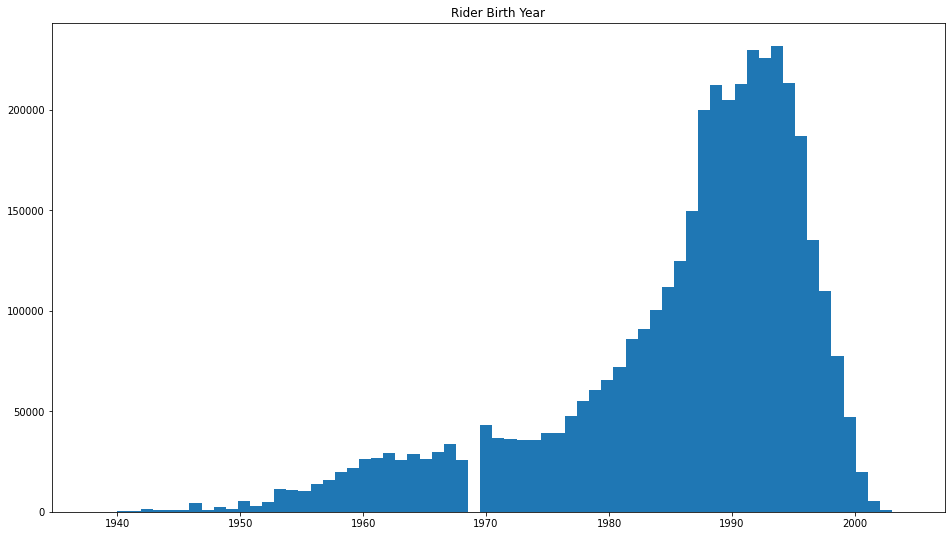

In [33]:
# Plots! - Age

df = data.drop(data[(data['age'] > 80) | (data['birth year'] == 1969)].index)

# Violin plot of Rider Age
fig = plt.figure(figsize=(10,12), facecolor='white')
ax = fig.add_subplot(1,1,1)

q50 = df['age'].quantile(0.5)
q75 = df['age'].quantile(0.75)
q25 = df['age'].quantile(0.25)
label = [f'25th Percentile: {q25:0.1f}\n50th Percentile: {q50:0.1f}\n75th Percentile: {q75:0.1f}']

collegeage = stats.percentileofscore(df['age'], 22) - stats.percentileofscore(df['age'], 18)
collegestr = f'{collegeage:0.0f}% of riders are undergraduate college aged (18-22)'
print(collegestr)

olderage = 100 - stats.percentileofscore(df['age'], 50)
olderstr = f'{olderage:0.0f}% of riders are above 50'
print(olderstr)

months = []
labels = []
# g = df.groupby([df['starttime'].dt.year, df['starttime'].dt.month_name()])
# g = df.groupby([df['starttime'].dt.year])

# for name, group in g:
#     # print(name)
#     # print(group.shape)
#     age = group['age']
#     # print(f'{name}\t{age.max()}')
#     months.append(age)
#     # labels.append(f'{name[1]} {name[0]}')

# ax.violinplot(dataset=months, quantiles=[.2,.5,.8], showextrema=False)
ax.violinplot(dataset=df['age'], quantiles=[.25,.5,.75], showextrema=False)

ax.set_xticks([1], labels=label)

ax.set_ylabel('Rider Age')
ax.set_title('Rider Age Distribution')
plt.show()


# Histogram of birth years
fig = plt.figure(figsize=(16,9), facecolor='white')
ax = fig.add_subplot(1,1,1)

bins = df['birth year'].max() - df['birth year'].min() + 1

ax.hist(df['birth year'], bins=bins)
ax.set_title('Rider Birth Year')
plt.show()

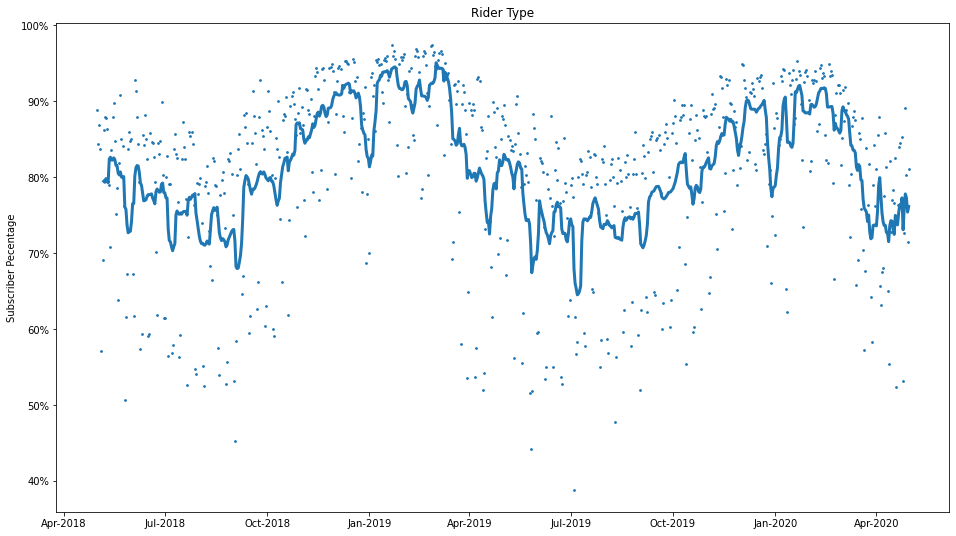

In [30]:
# Plots! - Rider Type
fig = plt.figure(figsize=(16,9), facecolor='white')
ax = fig.add_subplot(1,1,1)

usertype_roll = usertype.rolling(7).mean()
ax.scatter(usertype.index, usertype['usertype'], s=3)
ax.plot(usertype_roll, linewidth=3)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.set_ylabel('Subscriber Pecentage')
ax.set_title('Rider Type')
plt.show()

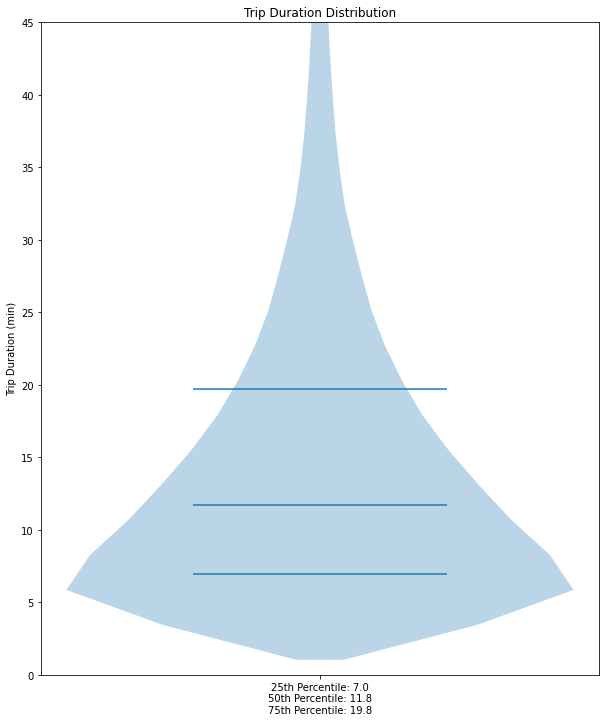

In [31]:
# Plots! - Trip Duration

df = data.drop(data[(data['tripduration'] > 4*60*60)].index)

q50 = data['tripduration'].quantile(0.5) / 60
q75 = data['tripduration'].quantile(0.75) / 60
q25 = data['tripduration'].quantile(0.25) / 60
label = [f'25th Percentile: {q25:0.1f}\n50th Percentile: {q50:0.1f}\n75th Percentile: {q75:0.1f}']

# Violin plot of Trip Duration
fig = plt.figure(figsize=(10,12), facecolor='white')
ax = fig.add_subplot(1,1,1)

ax.violinplot(dataset=df['tripduration']/60, quantiles=[.25,.5,.75], showextrema=False)

ax.set_xticks([1], labels=label)
ax.set_ylim([0,45])
ax.set_ylabel('Trip Duration (min)')
ax.set_title('Trip Duration Distribution')
plt.show()


# # Histogram of trip duration
# fig = plt.figure(figsize=(16,9))
# ax = fig.add_subplot(1,1,1)

# # bins = df['birth year'].max() - df['birth year'].min() + 1

# ax.hist(df['tripduration'])
# # ax.hist(df['tripduration'], bins=bins)
# ax.set_title('Trip Duration')
# plt.show()